In [10]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt 
import datetime
import sys
import geopandas as gpd
import pandas as pd
import seaborn as sns
import os
import xarray as xr
import netCDF4 as nc
import hvplot
import hvplot.dask
import hvplot.pandas
import hvplot.xarray
import glob
import rioxarray
from shapely.geometry import Polygon

# sns.set('paper')
try:
    import lxml
except Exception:
    !pip install lxml

### Get Grand Mesa base map (code from Ben Smith's lidar tutorial)

In [30]:
# GDAL environment variables to efficiently read remote data
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' 
os.environ['AWS_NO_SIGN_REQUEST']='YES' 

# SAR Data are stored in a public S3 Bucket
url = 's3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/12/S/YJ/2016/S1B_20161121_12SYJ_ASC/Gamma0_VV.tif'

# These Cloud-Optimized-Geotiff (COG) files have 'overviews', low-resolution copies for quick visualization
XR=[725000.0, 767000.0]
YR=[4.30e6, 4.34e6]
# open the dataset
da = rioxarray.open_rasterio(url, overview_level=1).squeeze('band')#.clip_box([712410.0, 4295090.0, 797010.0, 4344370.0])
da=da.where((da.x>XR[0]) & (da.x < XR[1]), drop=True)
da=da.where((da.y>YR[0]) & (da.y < YR[1]), drop=True)
dx=da.x[1]-da.x[0]
SAR_extent=[da.x[0]-dx/2, da.x[-1]+dx/2, np.min(da.y)-dx/2, np.max(da.y)+dx/2]

# Prepare coordinate transformations into the basemap coordinate system
from pyproj import Transformer, CRS
crs=CRS.from_wkt(da['spatial_ref'].spatial_ref.crs_wkt)
to_image_crs=Transformer.from_crs(crs.geodetic_crs, crs)
to_geo_crs=Transformer.from_crs(crs, crs.geodetic_crs)

corners_lon, corners_lat=to_geo_crs.transform(np.array(XR)[[0, 1, 1, 0, 0]], np.array(YR)[[0, 0, 1, 1, 0]])
lonlims=[np.min(corners_lat), np.max(corners_lat)]
latlims=[np.min(corners_lon), np.max(corners_lon)]

mm = [SAR_extent[ii].values for ii in range(4)]

---
## Download Cryosat-2 data
### API to download the data is from Tyler Sutterly's read-cryosat-2 package
https://github.com/tsutterley/read-cryosat-2.git

Note that it took me a pretty long time (did not finish overnight) to download the files - I think the querying
is pretty slow. 

(Deprecated cell)
You need to download the read-cryosat-2 tools and install them in your home directory.
In a terminal window, navigate to /home/jovyan/

Then:

`python3 -m pip install --user git+https://github.com/tsutterley/read-cryosat-2.git`

In [5]:
cs2_bound = gpd.read_file('CryoSat_Mask_4.0.kmz') #Load kmz with bounds of CryoSat-2 data

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


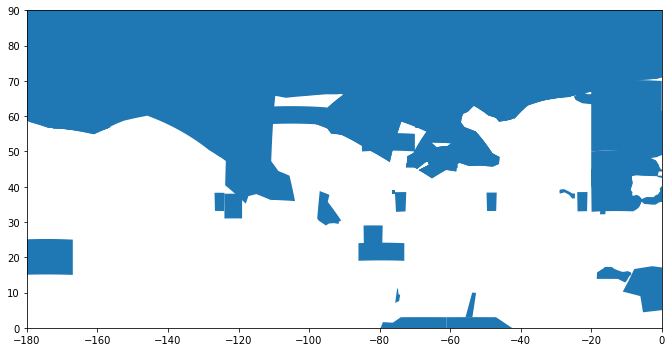

In [18]:
### Show everywhere that CryoSat-2 data exists (northern western hemisphere)
f1,a1 = plt.subplots(figsize=(10,5))
cs2_bound.plot(ax=a1)
a1.set_ylim(0,90)
a1.set_xlim(-180,0)
f1.tight_layout()

In [27]:
### Clip the extent of the CS2 geodataframe to the extent of Grand Mesa
bounding_box_GM = [-108.19, 39.03, -108.18, 39.04]
lon_pts = [bounding_box_GM[0],bounding_box_GM[2]]
lat_pts = [bounding_box_GM[1],bounding_box_GM[3]]
gdf = gpd.GeoDataFrame()
gdf['lat'] = lat_pts
gdf['lon'] = lon_pts
dim = 1  # define the length of the side of the square
geoms = []
for index, row in gdf.iterrows():
    ln = row.lon
    lt = row.lat
    geom = Polygon([(lon_pts[0], lat_pts[1]), (lon_pts[1], lat_pts[1]), (lon_pts[1], lat_pts[0]), (lon_pts[0], lat_pts[0])])
    geoms.append(geom)

gdf['geometry'] = geoms 
# gdf.crs = cs2_bound.crs
gdf.crs = crs="EPSG:4326"
inter = gpd.overlay(cs2_bound,gdf,how='intersection')
interUTM = inter.to_crs('EPSG:32612')

(4299996.445739257, 4339981.879096868)

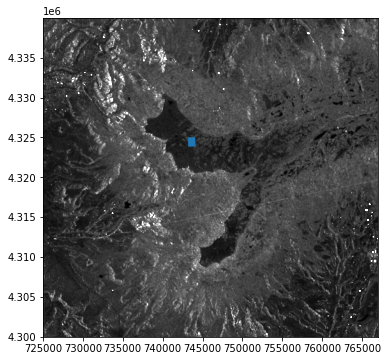

In [33]:
# Plot the interection between the SnowEx site and where CS2 dta exist
f1,a1=plt.subplots(figsize=(6,6))
a1.imshow(np.array(da)[::-1,:], origin='lower', extent=SAR_extent, cmap='gray', clim=[0, 0.5])
interUTM.plot(ax=a1)
a1.set_xlim(mm[0],mm[1])
a1.set_ylim(mm[2],mm[3])

In [ ]:
### We are going to use Tyler Sutterly's esa_cryosat_sync script to download the data from whereever CS2 is hosted

# If the script is not present in the current directory, download it!
# if you are working in a different directory you can alter the path below
if not os.path.isfile('esa_cryosat_sync.py'):
    !wget https://raw.githubusercontent.com/tsutterley/read-cryosat-2/main/scripts/esa_cryosat_sync.py
else:
    print('ESA_cryosat_sync.py already present')

import esa_cryosat_sync as ecs  #You might have to resart the kernel, or alter your sys.path to get this to work

In [ ]:
### Tyler's script is meant to be called from the command line
### Instead we are just calling the main function within the script

### Set the arguments for the data query
DIRECTORY = 'CS2data' # this is the directory to which the downloaded data will be saved
if not os.path.exists(DIRECTORY): #create that directory if it does not exist yet
    os.mkdir(DIRECTORY)
PRODUCT = 'SIR_SIN_L2' # this is the CS2 product you will download.
BBOX = [-108.19, 39.03, -108.18, 39.04] # the bounding box for the data you want.
YEARS = [2020] #must be a list, e.g. [2020] or [2019,2020]
LIST = True #True/False: if true, it will only search the database and list the files that fit the query; if true will download
#####
ecs.esa_cryosat_sync(PRODUCT, YEARS=YEARS, BASELINE='D', DIRECTORY=DIRECTORY,
    BBOX=BBOX, POLYGON=None, TIMEOUT=360, RETRY=5, LOG=False,
    LIST=LIST, MODE=0o775, CLOBBER=False)

### End download cryosat section
---

In [37]:
### Get names of all CS2 files
### the CS2 files for me are in a subdirectory of the Present Working Directory
### you may need to alter the path below to be specific to your file structure
fnames = glob.glob('./CS2data/SIR_SIN_L2/2020/*/*.nc',recursive=True)

In [38]:
### if you want to load a single CS2 pass
ds     = xr.open_dataset(fnames[1]) # load one file as an xarray dataset
hdf1   = ds.height_1_20_ku.to_dataframe() # put elevation track into a pandas dataframe. I am using the height_1_20_ku field; you will have to figure out what the different CS2 fields are!
gdf    = gpd.GeoDataFrame(hdf1, crs="EPSG:4326",geometry=gpd.points_from_xy(hdf1.lon_poca_20_ku, hdf1.lat_poca_20_ku)) # put into a geodataframe
gdfUTM = gdf.to_crs('EPSG:32612') # convert to EPSG:32612

In [88]:
'''
if you want to load all of the CS2 passes at once
xr.open_mfdataset was slow and did not work well
so open each file individually as an xarray dataset and put it into a dictionary
then each xarray dataset in the dictionary gets converted to its own geodataframe; again, those are all stored in a dictionary
'''
ds_dict     = {ii:xr.open_dataset(fnames[ii]) for ii in range(len(fnames))}
mdf_dict    = {ii:ds_dict[ii].height_1_20_ku.to_dataframe() for ii in range(len(ds_dict))}
gdf_dict    = {ii:gpd.GeoDataFrame(mdf_dict[ii], crs="EPSG:4326",geometry=gpd.points_from_xy(mdf_dict[ii].lon_poca_20_ku, mdf_dict[ii].lat_poca_20_ku)) for ii in range(len(mdf_dict))}
gdfUTM_dict = {ii:gdf_dict[ii].to_crs('EPSG:32612') for ii in range(len(mdf_dict))}
for ii in range(len(gdfUTM_dict)):
    gdfUTM_dict[ii]['x'] = gdfUTM_dict[ii].geometry.x.values
    gdfUTM_dict[ii]['y'] = gdfUTM_dict[ii].geometry.y.values

In [ ]:
### plot one pass
# f1,a1=plt.subplots(figsize=(8,8))
# a1.imshow(np.array(da)[::-1,:], origin='lower', extent=SAR_extent, cmap='gray', clim=[0, 0.5])
# gdfUTM.plot(ax=a1)
# a1.set_xlim(mm[0],mm[1])
# a1.set_ylim(mm[2],mm[3])

(4299996.445739257, 4339981.879096868)

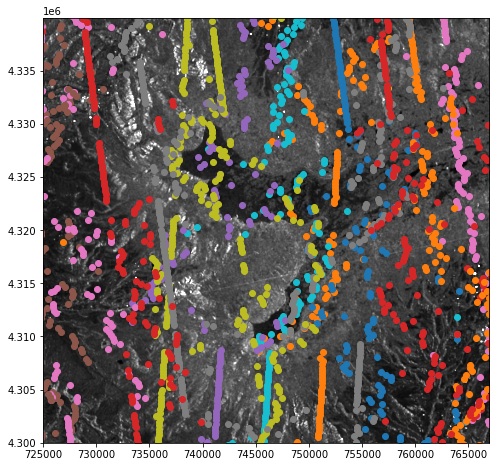

In [40]:
### plot the CS2 passes on the map

f1,a1=plt.subplots(figsize=(8,8))
a1.imshow(np.array(da)[::-1,:], origin='lower', extent=SAR_extent, cmap='gray', clim=[0, 0.5])
for ii in range(len(gdfUTM_dict)):
    gdfUTM_dict[ii].plot(ax=a1)
a1.set_xlim(mm[0],mm[1])
a1.set_ylim(mm[2],mm[3])

<AxesSubplot:xlabel='time_20_ku'>

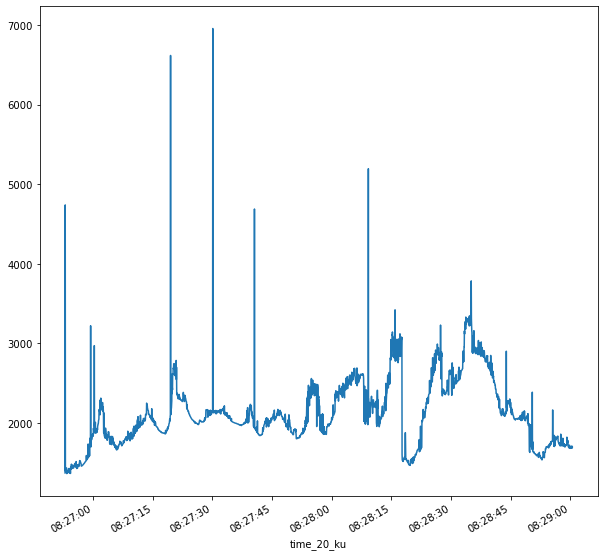

In [45]:
### plot elevations for one pass
f1,a1=plt.subplots(figsize = (10,10))
hdf1.height_1_20_ku.plot(ax=a1,label='1')

In [51]:
gdf.hvplot.scatter(x='lon_poca_20_ku',y = 'lat_poca_20_ku',datashade=True)

:DynamicMap   []
   :RGB   [lon_poca_20_ku,lat_poca_20_ku]   (R,G,B,A)

(4299996.445739257, 4339981.879096868)

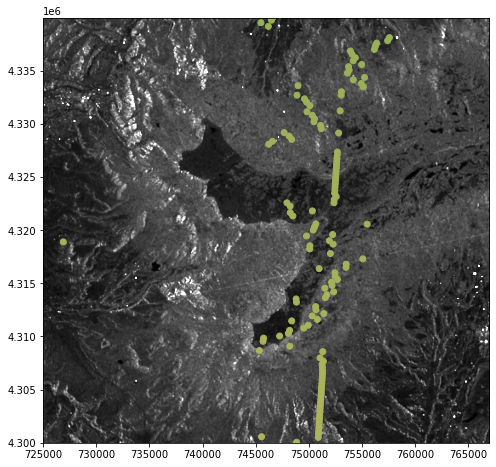

In [58]:
### plot one pass
f1,a1=plt.subplots(figsize=(8,8))
a1.imshow(np.array(da)[::-1,:], origin='lower', extent=SAR_extent, cmap='gray', clim=[0, 0.5])
gdfUTM.plot(ax=a1,c=gdfUTM.height_1_20_ku,cmap='gist_earth')
a1.set_xlim(mm[0],mm[1])
a1.set_ylim(mm[2],mm[3])

In [76]:
gdfUTM['x'] = gdfUTM.geometry.x.values
gdfUTM['y'] = gdfUTM.geometry.y.values

In [78]:
gdfUTM

,lat_poca_20_ku,lon_poca_20_ku,height_1_20_ku,geometry,x,y
time_20_ku,,,,,,
2020-06-23 08:26:52.918826880,43.999810,-107.450236,1371.527,POINT (784606.642 4877980.169),784606.642244,4.877980e+06
2020-06-23 08:26:52.963185024,44.050970,-108.245713,4738.435,POINT (720636.327 4881222.667),720636.327410,4.881223e+06
2020-06-23 08:26:53.007542016,43.995264,-107.462571,1395.056,POINT (783639.351 4877432.577),783639.351179,4.877433e+06
2020-06-23 08:26:53.051897984,43.992426,-107.460812,1393.794,POINT (783793.891 4877123.446),783793.890513,4.877123e+06
2020-06-23 08:26:53.096253056,43.991053,-107.479647,1386.113,POINT (782290.089 4876906.221),782290.088790,4.876906e+06
...,...,...,...,...,...,...
2020-06-23 08:29:00.351582080,36.272340,-108.416131,1695.053,POINT (732098.454 4017253.095),732098.454417,4.017253e+06
2020-06-23 08:29:00.395753088,36.266858,-108.381847,1710.603,POINT (735195.164 4016727.583),735195.164116,4.016728e+06
2020-06-23 08:29:00.439923968,36.267950,-108.428804,1683.795,POINT (730972.762 4016735.729),730972.761618,4.016736e+06


AttributeError: 'PathCollection' object has no property 'extend'

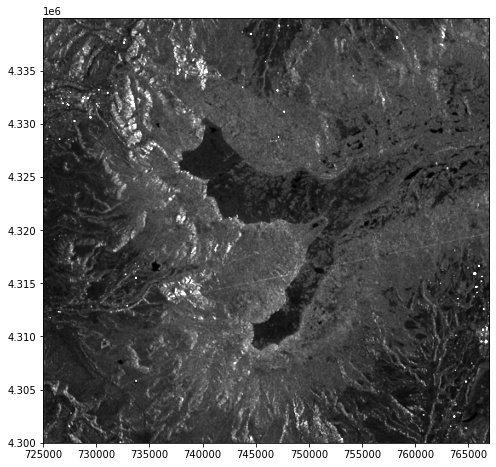

In [93]:
f1,a1= plt.subplots(figsize=(8,8))
a1.imshow(np.array(da)[::-1,:], origin='lower', extent=SAR_extent, cmap='gray', clim=[0, 0.5])#plt.figure();
lels = np.linspace(1500,5000,256)
for ii in range(len(gdfUTM_dict)):    
    cax1 = a1.scatter(gdfUTM_dict[ii]['x'], gdfUTM_dict[ii]['y'],4, c=gdfUTM_dict[ii]['height_1_20_ku'], cmap='gist_earth', extend='both',levels = lels)
    cax1.cmap.set_over('black')
    cax1.cmap.set_under('black')
f1.colorbar(cax1)
a1.set_xlim(mm[0],mm[1])
a1.set_ylim(mm[2],mm[3])